# MLND CAPSTONE PROJECT

**Project Summary:**  

In this project, we will train a model that can decode sequences of digits from natural images, and create an app that prints the numbers it sees in real time using Tensorflow library.

The data that we will be using is Street View House Numbers (SVHN), a large-scale dataset of house numbers in Google Street View images.

## Download matlab data

In [32]:
# Import required modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf

from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [33]:
# Download SVHN data from Stanford University repo
from urllib import urlretrieve
    
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  print('Found and downloaded', filename)
  return filename

In [34]:
# Download train, test and extra 32_32 matlab files for cropped digits
train_filename = maybe_download('train_32x32.mat')
test_filename = maybe_download('test_32x32.mat')
extra_filename = maybe_download('extra_32x32.mat')

Found and downloaded train_32x32.mat
Found and downloaded test_32x32.mat
Found and downloaded extra_32x32.mat


In [35]:
# Load matlab files using scipy.io library
import scipy.io as sio

train_data = sio.loadmat('train_32x32.mat', variable_names='X').get('X')
train_labels = sio.loadmat('train_32x32.mat', variable_names='y').get('y')
test_data = sio.loadmat('test_32x32.mat', variable_names='X').get('X')
test_labels = sio.loadmat('test_32x32.mat', variable_names='y').get('y')
# extra_data = sio.loadmat('extra_32x32.mat', variable_names='X').get('X')
# extra_labels = sio.loadmat('extra_32x32.mat', variable_names='y').get('y')

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
# print("extra data: ", extra_data.shape, extra_labels.shape)

train data:  (32, 32, 3, 73257) (73257, 1)
test data:  (32, 32, 3, 26032) (26032, 1)


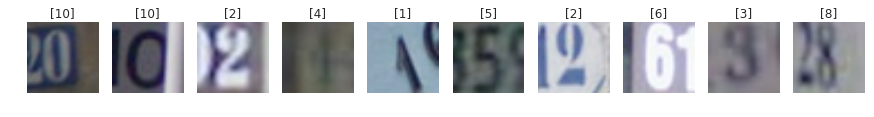

In [36]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[:,:,:,j])

## Pre-processing Data

In [37]:
# first we will normalize image data in range of -1 and 1.
train_data = train_data.astype('float32') / 128.0 - 1
test_data = test_data.astype('float32') / 128.0 - 1

# reshaping np array so that we can access data in CNN friendly format i.e. [i,:,:,:] from [:,:,:,i]
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data,(3, 0, 1, 2))

#chaning class labels range 1-10 to 0-9
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

# processing labels in CNN friendly format i.e. 1-hot-encoding
num_labels = 10
train_labels = train_labels[:,0]
test_labels = test_labels[:,0]
train_labels = (np.arange(num_labels) == train_labels[:, None]).astype(np.float32)
test_labels = (np.arange(num_labels) == test_labels[:, None]).astype(np.float32)

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
print("sample one-hot encoding train label: ", train_labels[3])

train data:  (73257, 32, 32, 3) (73257, 10)
test data:  (26032, 32, 32, 3) (26032, 10)
sample one-hot encoding train label:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [38]:
# Create Validation data from Train data
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, 
                                                                      test_size=0.1, random_state=42)

print("train data: ", train_data.shape, train_labels.shape)
print("valid data: ", valid_data.shape, valid_labels.shape)

train data:  (65931, 32, 32, 3) (65931, 10)
valid data:  (7326, 32, 32, 3) (7326, 10)


In [39]:
# shuffle dataset
from sklearn.utils import shuffle

train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
test_data, test_labels = shuffle(test_data, test_labels, random_state=0)

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
print("valid data: ", valid_data.shape, valid_labels.shape)

train data:  (65931, 32, 32, 3) (65931, 10)
test data:  (26032, 32, 32, 3) (26032, 10)
valid data:  (7326, 32, 32, 3) (7326, 10)


In [40]:
# Create pickle file to save processed data
pickle_file = 'SVHN_single.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_data': train_data,
    'train_labels': train_labels,
    'test_data': test_data,
    'test_labels': test_labels
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1133720175


## Training the Model

In [41]:
# lets load data from pickle file we previously stored
data_file = 'SVHN_single.pickle' # redefined varaible in case you have completed above steps previously.

print('Tring to load pickle from %s' % data_file)

with open(data_file, 'rb') as file:
    svhn_datasets = pickle.load(file)
    train_data = svhn_datasets['train_data']
    train_labels = svhn_datasets['train_labels']
    test_data = svhn_datasets['test_data']
    test_labels = svhn_datasets['test_labels']
    del svhn_datasets # free up memory
    print('pickle loaded successfully!')

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
print("valid data: ", valid_data.shape, valid_labels.shape)

Tring to load pickle from SVHN_single.pickle
pickle loaded successfully!
train data:  (65931, 32, 32, 3) (65931, 10)
test data:  (26032, 32, 32, 3) (26032, 10)
valid data:  (7326, 32, 32, 3) (7326, 10)


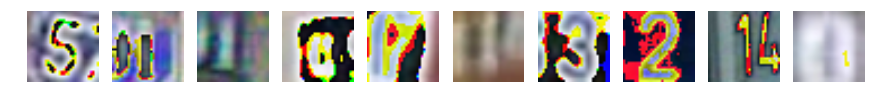

In [42]:
# Check to make sure image from pickle file is valid

plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    # we will not display labels here as 1-hot-encoding cannot be viewed properly in little place
    ax[i].imshow(train_data[j,:,:,:])

## Prepare CNN using TensorFlow

In [43]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Covnet model: conv1/pool1/conv2/pool2/conv3/pool3/fc1/dropout/fc2/softmax

In [45]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 256

graph = tf.Graph()

with graph.as_default():

    def weight_varible(shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_varible(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'SAME')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_data)
    tf_test_dataset = tf.constant(test_data)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = weight_varible([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_varible([depth1]) # 16
    # conv2 layer 2
    layer2_weights = weight_varible([patch_size, patch_size, depth1, depth2]) # in depth1, out depth2
    layer2_biases = bias_varible([depth2]) # 32
    # conv3 layer 3
    layer3_weights = weight_varible([patch_size, patch_size, depth2, depth3]) # in depth2, out depth3
    layer3_biases = bias_varible([depth3]) # 64
    
    
    # func1 layer 4
    layer4_weights = weight_varible([image_size // 8 * image_size // 8 * depth3, num_hidden])
    layer4_biases = bias_varible([num_hidden])
    # func2 layer 5
    layer5_weights = weight_varible([num_hidden, num_labels])
    layer5_biases = bias_varible([num_labels])
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        # conv3 layer 3
        hidden3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth2
        pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # func1 layer 4
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, 0.5)
        # func2 layer 5
        prediction = tf.matmul(hidden4_drop, layer5_weights) + layer5_biases
        return prediction
    
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(1e-4, global_step=global_step, decay_steps=10000, decay_rate=0.97)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [46]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("step: %d, training accuracy: %g, validation accuracy: %g" % 
                  (step, accuracy(predictions, batch_labels)/100, accuracy(
            valid_prediction.eval(), valid_labels)/100 ))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
step: 0, training accuracy: 0.109375, validation accuracy: 0.127355
step: 500, training accuracy: 0.28125, validation accuracy: 0.30303
step: 1000, training accuracy: 0.53125, validation accuracy: 0.538493
step: 1500, training accuracy: 0.71875, validation accuracy: 0.649331
step: 2000, training accuracy: 0.78125, validation accuracy: 0.706934
step: 2500, training accuracy: 0.78125, validation accuracy: 0.742697
step: 3000, training accuracy: 0.8125, validation accuracy: 0.767677
step: 3500, training accuracy: 0.78125, validation accuracy: 0.785831
step: 4000, training accuracy: 0.78125, validation accuracy: 0.796888
step: 4500, training accuracy: 0.640625, validation accuracy: 0.808627
step: 5000, training accuracy: 0.765625, validation accuracy: 0.818728
step: 5500, training accuracy: 0.8125, validation accuracy: 0.824597
step: 6000, training accuracy: 0.8125, validation accuracy: 0.822004
step: 6500, training accuracy: 0.828125, validation accuracy: 0.831968
step: 7000, 